In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  ##要用 .annotate的話，  matplotlib.__version__==2.0.2 較沒有問題
import seaborn as sns
from collections import Counter
from bokeh.charts import TimeSeries, output_file, show
plt.rcParams['axes.unicode_minus']=False #正常顯示負號
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體

%matplotlib inline
plt.style.use('seaborn')

C:\ProgramData\Anaconda3\lib\site-packages\bokeh\util\deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


In [2]:
df = pd.read_csv('Prices.csv', parse_dates=True)

df = df[['Name', 'US dollar', 'G5 currency index', 'Producer index', 'Consumer index']]  ## 只留下要的欄位
df_day= pd.DataFrame(columns = ['30_day', '60_day', '120_day', '240_day'])  ## 新增日均線欄位
df = pd.concat([df,df_day], axis = 1)  ## 新舊dataframe合併

df.columns = df.columns.str.replace(' ','_')   # 把欄位名稱的 空格 改成 "_"
df=df.rename(columns = {'Name':'Date'})   ## 把 Name欄位名稱 改成 Date

df['US_dollar'] = df['US_dollar'].str.replace(',','')  ##US_dollar裡面有值有","  先換掉才能轉float 
df[['US_dollar', '30_day', '60_day', '120_day', '240_day']] = \
                          df[['US_dollar', '30_day', '60_day', '120_day', '240_day']].astype('float')   ## US_dollar轉 float
df['Date'] = pd.to_datetime(df.Date, errors = 'raise')    ## date 轉 datetime
df = df.set_index(df['Date'], drop = True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10131 entries, 1978-12-29 to 2017-10-27
Data columns (total 9 columns):
Date                 10131 non-null datetime64[ns]
US_dollar            10131 non-null float64
G5_currency_index    10129 non-null float64
Producer_index       6470 non-null float64
Consumer_index       8560 non-null float64
30_day               0 non-null float64
60_day               0 non-null float64
120_day              0 non-null float64
240_day              0 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 791.5 KB


,Date,US_dollar,G5_currency_index,Producer_index,Consumer_index,30_day,60_day,120_day,240_day
Date,,,,,,,,,
1978-12-29,1978-12-29,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-01,1979-01-01,226.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-02,1979-01-02,226.8,132.5,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-03,1979-01-03,218.6,134.2,NaN,NaN,NaN,NaN,NaN,NaN
1979-01-04,1979-01-04,223.2,134.0,NaN,NaN,NaN,NaN,NaN,NaN


## 日均線 新增值

In [3]:
## 用迴圈 新增一個list 內容為前30天平均 - 比較麻煩der方法
'''
i = 30
list1 = []
for i in range(len(df['US_dollar'])):
    if i < len(df['US_dollar']+1):
        s = df.iloc[i-30:i, 1].mean()
        list1.append(s)
del list1[0]  ## 刪掉第一個觀察值  位置才會對
df1 = pd.DataFrame({'30_day':list1}, dtype = 'float') ## list 轉 DataFrame
df = pd.concat([df, df1], axis = 1)  #合併到欄
df[28:32]
'''

"\ni = 30\nlist1 = []\nfor i in range(len(df['US_dollar'])):\n    if i < len(df['US_dollar']+1):\n        s = df.iloc[i-30:i, 1].mean()\n        list1.append(s)\ndel list1[0]  ## 刪掉第一個觀察值  位置才會對\ndf1 = pd.DataFrame({'30_day':list1}, dtype = 'float') ## list 轉 DataFrame\ndf = pd.concat([df, df1], axis = 1)  #合併到欄\ndf[28:32]\n"

In [4]:
## 測試用
#df.iloc[0:1 ,5] = df.iloc[0:30,1].mean()
#df.iloc[0:1 ,5]

In [5]:
t = 30; s = 60; tlf = 120; ttf = 240
for num in range(len(df['US_dollar'])+1):
    df.iloc[t-1:t, 5] = df.iloc[t-30:t, 1].mean()
    t += 1
    df.iloc[s-1:s, 6] = df.iloc[s-60:s, 1].mean()
    s += 1
    df.iloc[tlf-1:tlf, 7] = df.iloc[tlf-120:tlf, 1].mean()
    tlf += 1
    df.iloc[ttf-1:ttf, 8] = df.iloc[ttf-240:ttf, 1].mean()
    ttf += 1
    
df[10128:]

,Date,US_dollar,G5_currency_index,Producer_index,Consumer_index,30_day,60_day,120_day,240_day
Date,,,,,,,,,
2017-10-25,2017-10-25,1275.0,446.4,635.7,891.7,1289.240000,1293.971667,1272.010000,1242.830833
2017-10-26,2017-10-26,1273.8,447.1,638.2,897.8,1287.546667,1294.066667,1272.431667,1243.196250
2017-10-27,2017-10-27,1266.5,444.1,636.8,893.7,1285.666667,1294.213333,1272.725000,1243.524583


In [6]:
#### 日均線 - 一個一個來版本 #####
## 迴圈 for 30日平均
'''
i = 30
for i in range(len(df['US_dollar'])+1):
    df.iloc[i-1:i, 5] = df.iloc[i-30:i, 1].mean()
    i += 1
    
## 迴圈 for 60日平均
i = 60
for i in range(len(df['US_dollar'])+1):
    df.iloc[i-1:i, 6] = df.iloc[i-60:i, 1].mean()
    i += 1
    
## 迴圈 for 120日平均
i = 120
for i in range(len(df['US_dollar'])+1):
    df.iloc[i-1:i, 7] = df.iloc[i-120:i, 1].mean()
    i += 1
    
## 迴圈 for 240日平均
i = 240
for i in range(len(df['US_dollar'])+1):
    df.iloc[i-1:i, 8] = df.iloc[i-240:i, 1].mean()
    i += 1
    
df[10128:]
'''

"\ni = 30\nfor i in range(len(df['US_dollar'])+1):\n    df.iloc[i-1:i, 5] = df.iloc[i-30:i, 1].mean()\n    i += 1\n    \n## 迴圈 for 60日平均\ni = 60\nfor i in range(len(df['US_dollar'])+1):\n    df.iloc[i-1:i, 6] = df.iloc[i-60:i, 1].mean()\n    i += 1\n    \n## 迴圈 for 120日平均\ni = 120\nfor i in range(len(df['US_dollar'])+1):\n    df.iloc[i-1:i, 7] = df.iloc[i-120:i, 1].mean()\n    i += 1\n    \n## 迴圈 for 240日平均\ni = 240\nfor i in range(len(df['US_dollar'])+1):\n    df.iloc[i-1:i, 8] = df.iloc[i-240:i, 1].mean()\n    i += 1\n    \ndf[10128:]\n"

###  US_dollar與時間折線圖

In [7]:
## 找要標記的點

print('US_dollar max =', df['US_dollar'].max())
print('=====================================================')
print(df[df['US_dollar']==1895.0])

US_dollar max = 1895.0
                 Date  US_dollar  G5_currency_index  Producer_index  \
Date                                                                  
2011-09-05 2011-09-05     1895.0              450.5           629.9   
2011-09-06 2011-09-06     1895.0              451.4           631.4   

            Consumer_index       30_day       60_day      120_day      240_day  
Date                                                                            
2011-09-05           866.6  1749.566667  1647.146667  1570.536667  1472.478750  
2011-09-06           867.3  1758.973333  1653.463333  1574.445000  1474.830833  


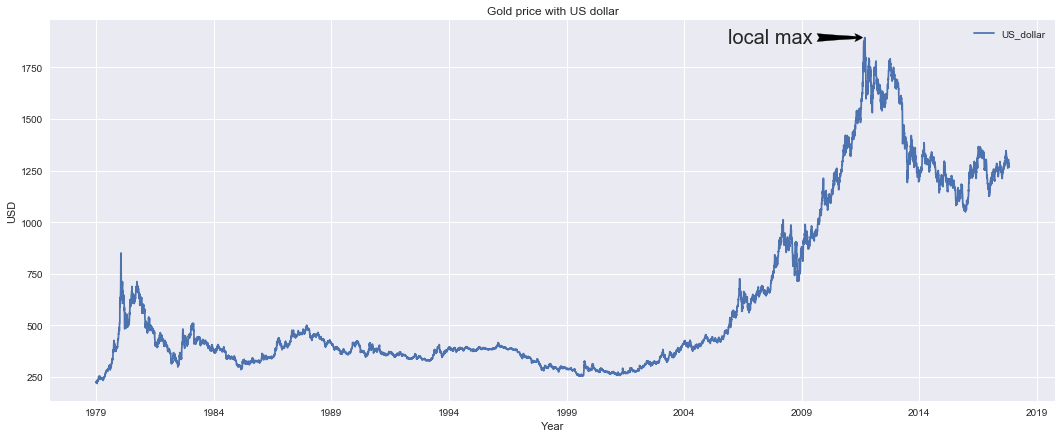

In [8]:
## https://matplotlib.org/users/annotations.html
plt.figure(figsize=(18,7))
plt.plot(df['Date'], df['US_dollar'], )
plt.title('Gold price with US dollar')   ## 圖片標題
plt.xlabel('Year')    ## X軸標題
plt.ylabel('USD')    ## Y軸標題
plt.legend()  ## 顯示標籤
#plt.xlim('1978-12-29','2018-01-01')  ## X軸範圍設定

## 讓電腦自己算點在哪
ymax = max(df['US_dollar'])
xpos = list(df['US_dollar']).index(1895)
xmax = df.Date[xpos]

##  va='bottom:上 , center:置中, top:下'   , ha='right:文字左端為座標點, center:文字置中, right:文字右端為座標點
##                  要註記的文字              xy=要標記的點                xytext=文字起始點
plt.annotate('local max', xy=(xmax, ymax), xytext=('2007-09-05', ymax), size = 20,
            va="center", ha="center", arrowprops=dict(facecolor='black', arrowstyle='fancy')#, shrink=0.05
            )

plt.savefig('GoldPrice_USdollar.jpg')

## 時間 & 金價、30日、60日、120日、240日 折線圖

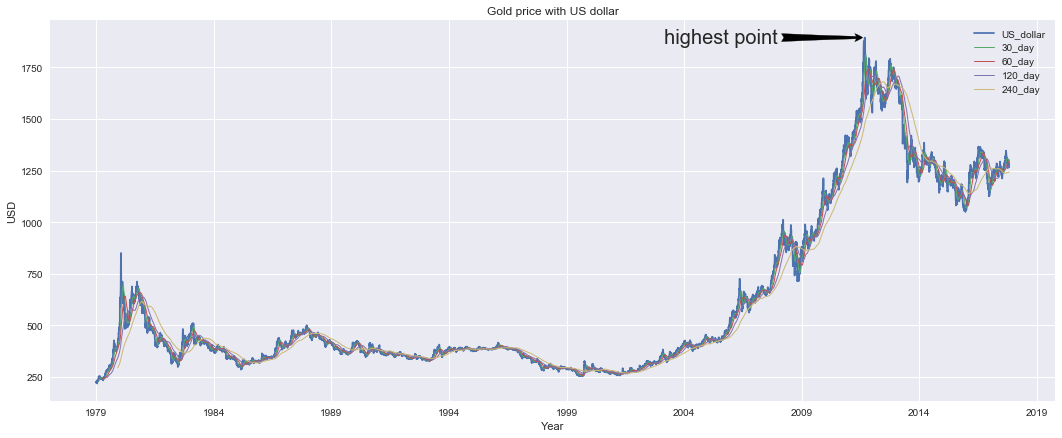

In [9]:
#plt.plot(df['Date'], df['US_dollar'])
plt.figure(figsize=(18,7))
plt.plot(df['Date'], df['US_dollar'])
plt.plot(df['Date'], df['30_day'], lw = 1)
plt.plot(df['Date'], df['60_day'], lw = 1)
plt.plot(df['Date'], df['120_day'], lw = 1)
plt.plot(df['Date'], df['240_day'], lw = 1)

plt.title('Gold price with US dollar')   ## 圖片標題
plt.xlabel('Year')    ## X軸標題
plt.ylabel('USD')    ## Y軸標題
plt.legend()  ## 顯示標籤

plt.annotate('highest point', xy=('2011-09-05', '1895'), xytext=('2005-07-20', 1895),size=20,\
             va="center", ha="center",arrowprops=dict(facecolor='black', arrowstyle='fancy'))

plt.savefig('GoldPrice.jpg')

## 金價 & 時間 折線圖(us_dollar, 30日、60日、120日、240日) - html 可縮放版

In [10]:
df_plot = df[['US_dollar', '30_day', '60_day', '120_day', '240_day']]
p = TimeSeries(df_plot, title="GOLD", ylabel='US dollar', xlabel = 'Year', width=1200, height=600)
output_file("gold_price_timeseries.html")
show(p)
df_plot[10128:]

E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='18c61d34-2b1c-4327-8385-9070f515f53e', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='2eb594ab-d72d-497e-85b0-0733c866d361', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='49069b2f-3599-406c-8187-f301447ca72c', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='76811e7d-6c73-4ebf-8575-339798d9f090', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='e10c1a14-ef8d-4ce0-9bab-97b578f360fd', ...)


,US_dollar,30_day,60_day,120_day,240_day
Date,,,,,
2017-10-25,1275.0,1289.240000,1293.971667,1272.010000,1242.830833
2017-10-26,1273.8,1287.546667,1294.066667,1272.431667,1243.196250
2017-10-27,1266.5,1285.666667,1294.213333,1272.725000,1243.524583


# Gold_demand 長條圖

In [12]:
gd = pd.read_csv('Gold_demand.csv')
gd = gd.set_index(gd['Year'], drop = True)
del gd['Year']
gd = gd[:7]
gd

,Jewellery,Technology,Total bar and coin demand,ETFs & similar products*,Central banks & other inst.
Year,,,,,
2010,2053.812635,460.497351,1203.614796,420.405815,79.150503
2011,2094.444857,428.586667,1497.926689,236.842932,480.786497
2012,2134.919952,381.339577,1303.479362,306.585759,569.347245
2013,2695.443046,355.923128,1715.722501,-914.327874,623.846705
2014,2492.037473,348.671368,1045.170532,-182.904007,583.901607
2015,2404.400002,331.963746,1066.696214,-128.315891,576.537131
2016,2046.741905,323.432572,1043.246387,534.245802,389.752900


# 歷年黃金需求者 需求量

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


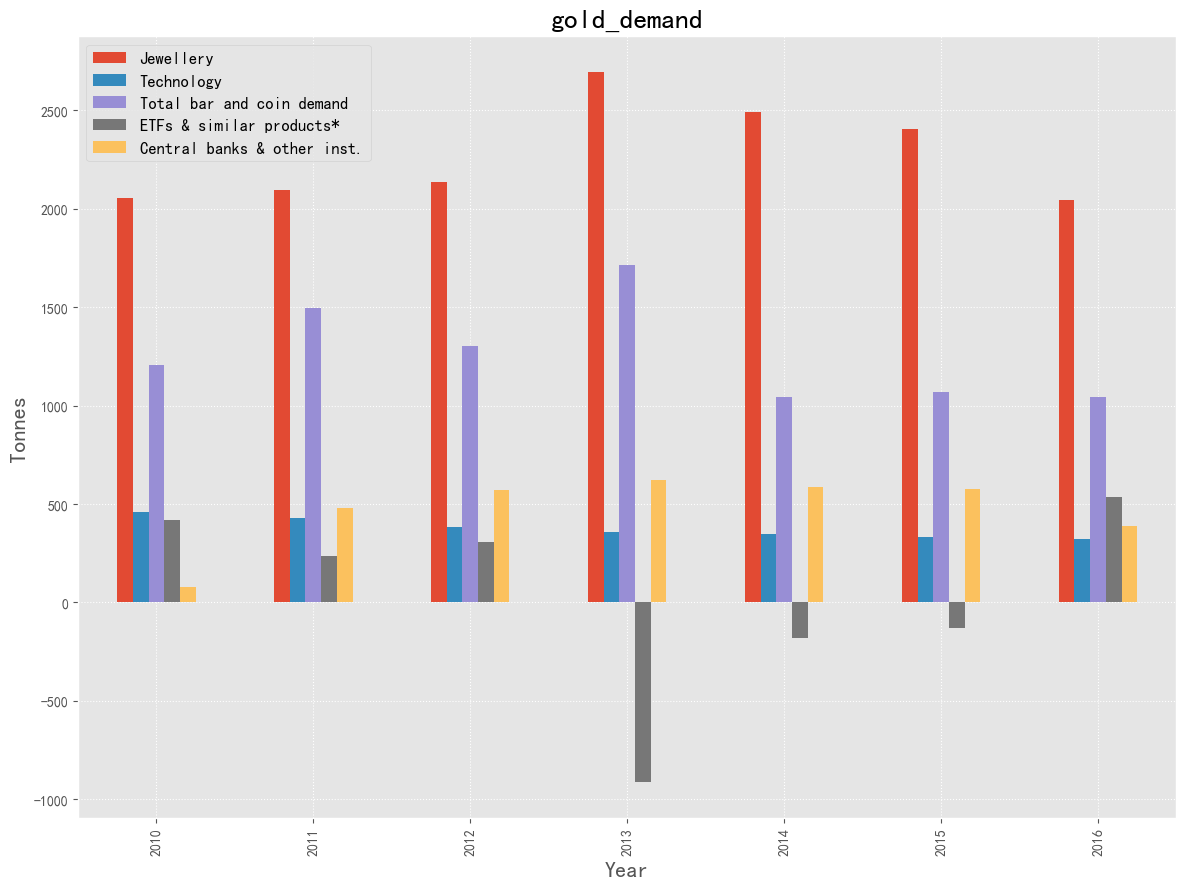

In [13]:
plt.rcdefaults()  ##重置 plt.rcParams
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
plt.rcParams['axes.unicode_minus'] = False #正常顯示負號
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['axes.labelsize'] = 16  # 設定x y軸 label 字體大小
plt.rcParams['axes.titlesize'] = 20    # 設定標題大小
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.dpi'] = 300 #圖片像素
plt.rcParams['ytick.major.size'] = 3.5  # Y軸刻度 長度
plt.rcParams['figure.autolayout'] =True    # plt.tight_layout()
plt.rcParams['legend.fontsize'] = 12  # 設定 legend 大小
plt.rcParams['savefig.transparent'] = True  # 存檔背景透明
plt.rcParams['savefig.bbox'] = 'tight'  # 把所有的標籤都存進圖片(不會被切掉)

gd.plot(kind='bar')
plt.title('gold_demand')
plt.ylabel('Tonnes')
plt.xlabel('Year')
plt.savefig('gold_demand for all year.png')

# 黃金需求者 for each year

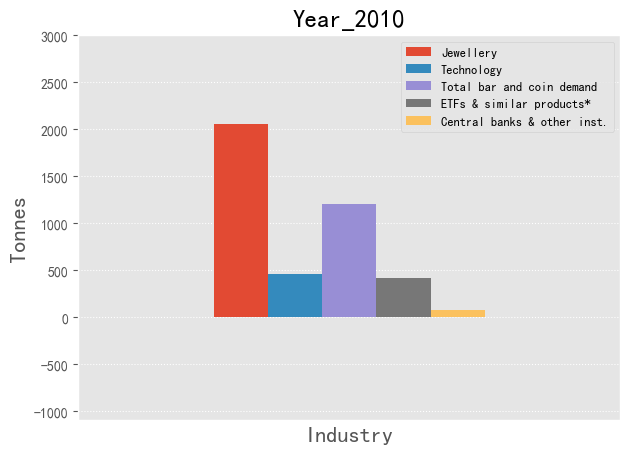

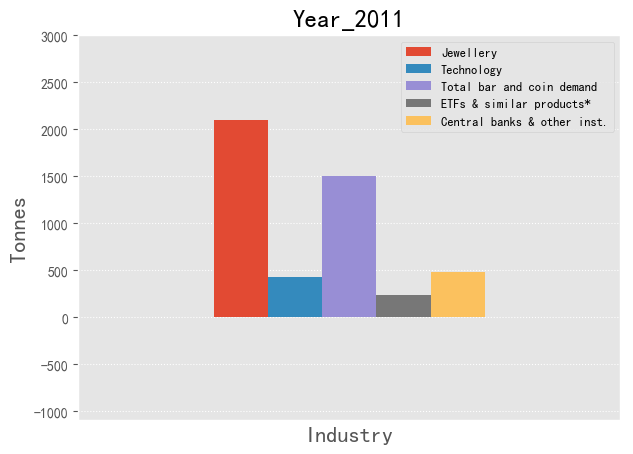

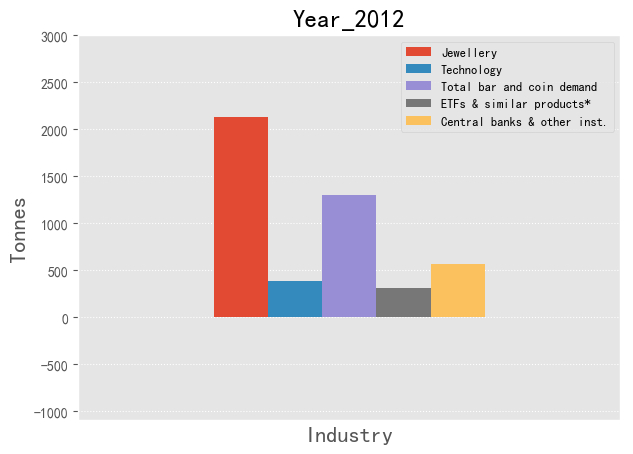

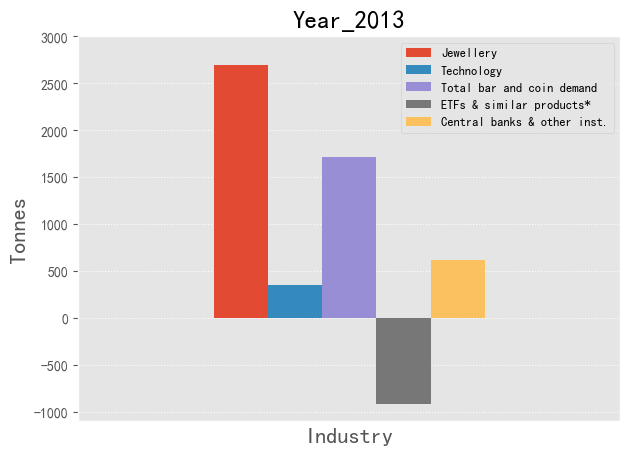

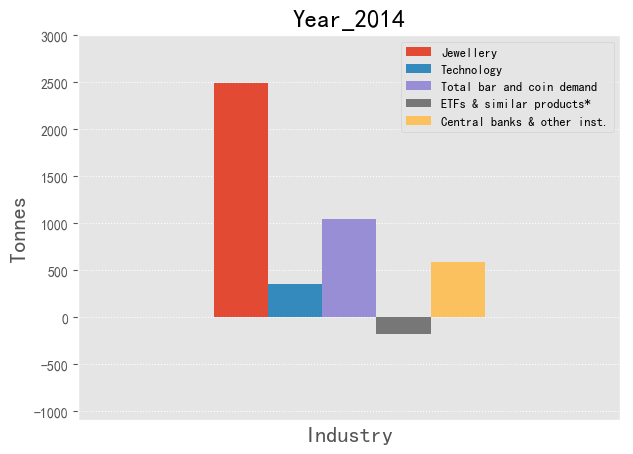

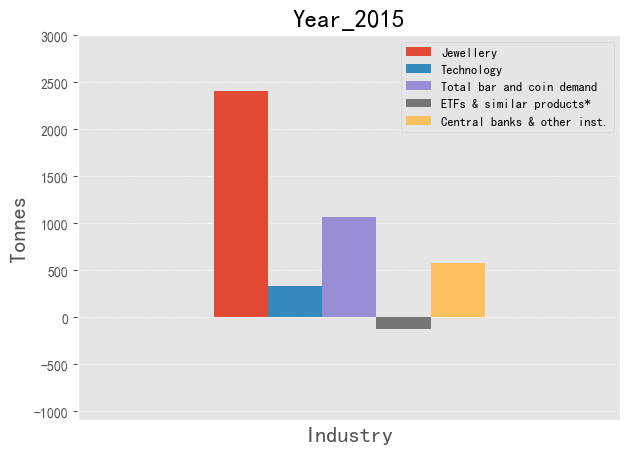

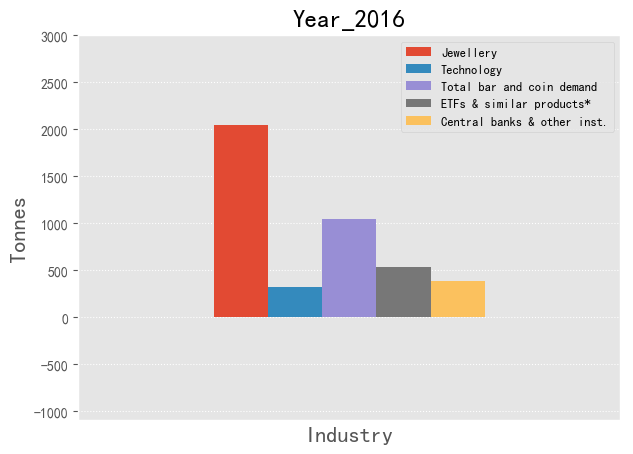

In [14]:
plt.rcdefaults()  ##重置 plt.rcParams
plt.style.use('ggplot')
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
plt.rcParams['axes.unicode_minus'] = False #正常顯示負號
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.labelsize'] = 16  # 設定x y軸 label 字體大小
plt.rcParams['axes.titlesize'] = 18    # 設定標題大小
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.dpi'] = 300 #圖片像素
plt.rcParams['ytick.major.size'] = 3.5  # Y軸刻度 長度
plt.rcParams['legend.fontsize'] = 9  # 設定 legend 大小
plt.rcParams['savefig.transparent'] = True  # 存檔背景透明
plt.rcParams['savefig.bbox'] = 'tight'  # 把所有的標籤都存進圖片(不會被切掉)


gd[0:1].plot(kind='bar')
plt.title('Year_2010') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2010_gold_demand.png')

gd[1:2].plot(kind='bar')
plt.title('Year_2011') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2011_gold_demand.png')

gd[2:3].plot(kind='bar')
plt.title('Year_2012') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2012_gold_demand.png')

gd[3:4].plot(kind='bar')
plt.title('Year_2013') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2013_gold_demand.png')

gd[4:5].plot(kind='bar')
plt.title('Year_2014') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2014_gold_demand.png')

gd[5:6].plot(kind='bar')
plt.title('Year_2015') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2015_gold_demand.png')

gd[6:7].plot(kind='bar')
plt.title('Year_2016') ; plt.ylabel('Tonnes') ; plt.xlabel('Industry')
plt.ylim(-1100, 3000)
plt.xticks([])
plt.savefig('2016_gold_demand.png')


# 黃金儲備統計

In [15]:
gr = pd.read_csv('gold_reserve_new.csv')
gr['Year'] = pd.to_datetime(gr.Year, errors = 'raise')    ## date 轉 datetime
gr = gr.set_index(gr['Year'], drop = True)
gr.info()
gr.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2000-03-31 to 2017-03-31
Data columns (total 16 columns):
Year             18 non-null datetime64[ns]
United States    18 non-null float64
Germany          18 non-null float64
IMF              18 non-null float64
Italy            18 non-null int64
France           18 non-null float64
China            18 non-null float64
Russia           18 non-null float64
Switzerlan       18 non-null float64
Japan            18 non-null float64
Netherlands      18 non-null float64
India            18 non-null int64
BIS              18 non-null float64
ECB              18 non-null float64
Turkey           18 non-null float64
Taiwan           18 non-null float64
dtypes: datetime64[ns](1), float64(13), int64(2)
memory usage: 2.4 KB


,Year,United States,Germany,IMF,Italy,France,China,Russia,Switzerlan,Japan,Netherlands,India,BIS,ECB,Turkey,Taiwan
Year,,,,,,,,,,,,,,,,
2000-03-31,2000-03-31,8137.50,3469.00,3217.0,2452,3025.00,395.00,379.00,2504.00,759.00,912.00,358,199.00,747.0,116.0,421.50
2001-03-31,2001-03-31,8142.50,3463.00,3217.0,2452,3025.00,421.50,403.50,2289.00,764.75,898.00,358,197.00,767.0,116.0,422.00
2002-03-31,2002-03-31,8149.00,3446.50,3217.0,2452,3025.00,525.25,397.25,2023.25,765.00,872.25,358,197.00,767.0,116.0,421.50
2003-03-31,2003-03-31,8135.00,3442.25,3217.0,2452,3025.00,600.00,388.25,1740.50,765.00,825.00,358,193.25,767.0,116.0,422.25
2004-03-31,2004-03-31,8135.75,3435.50,3217.0,2452,3014.75,600.00,389.00,1456.50,765.00,777.00,358,207.00,767.0,116.0,422.50


# 歷年前15大黃金儲備量 - 依年份作圖

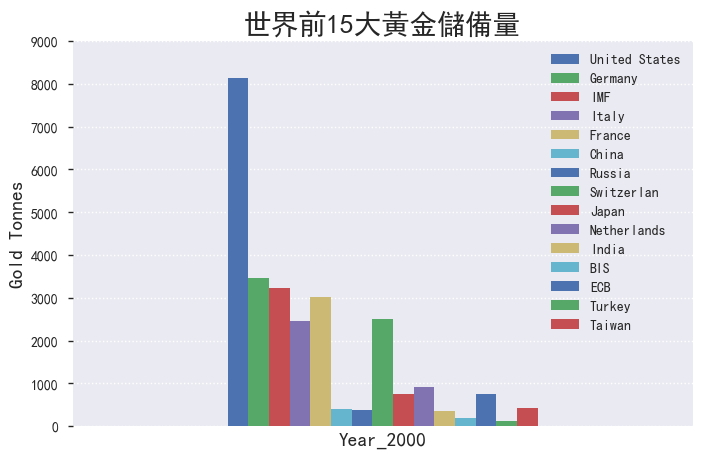

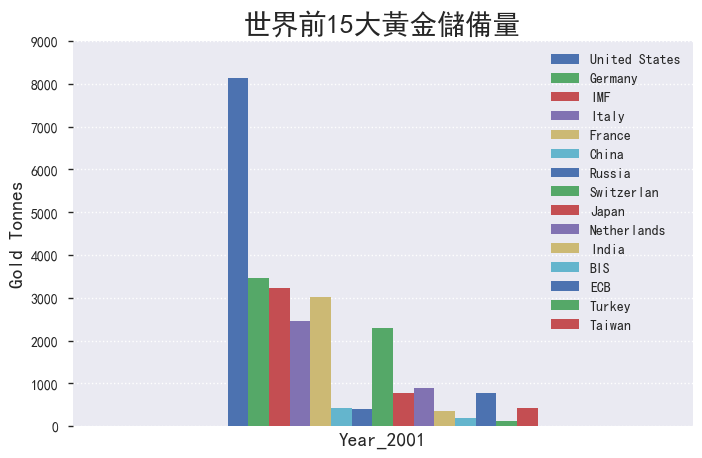

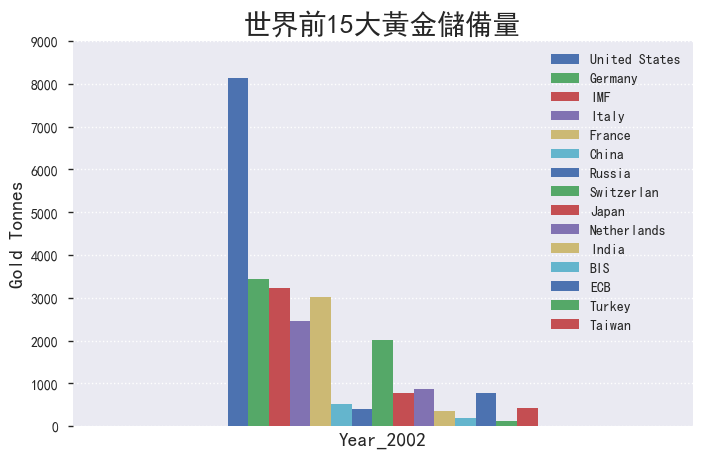

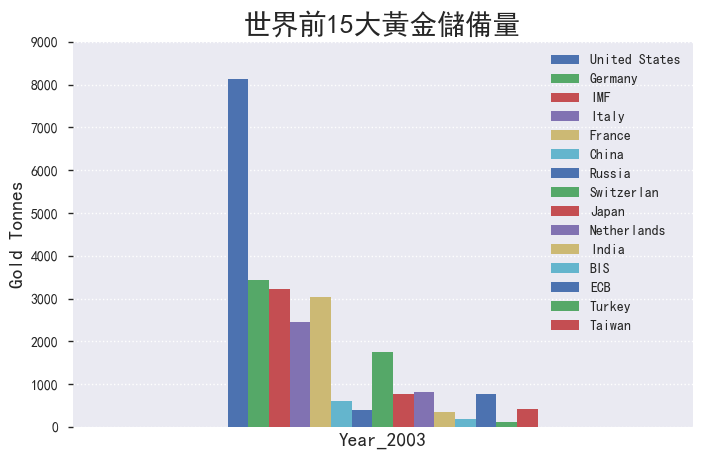

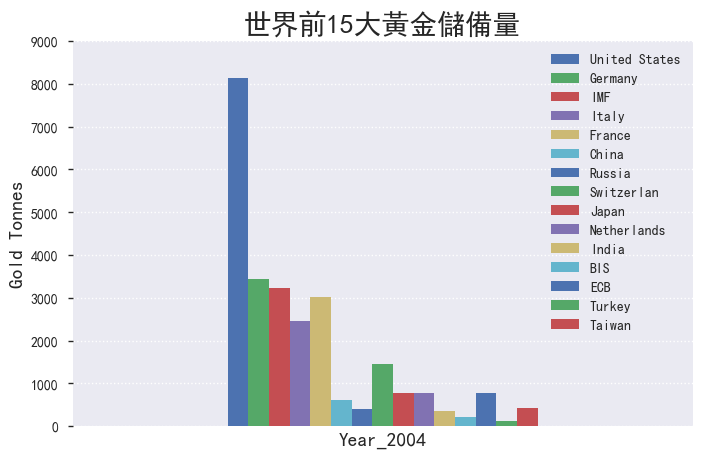

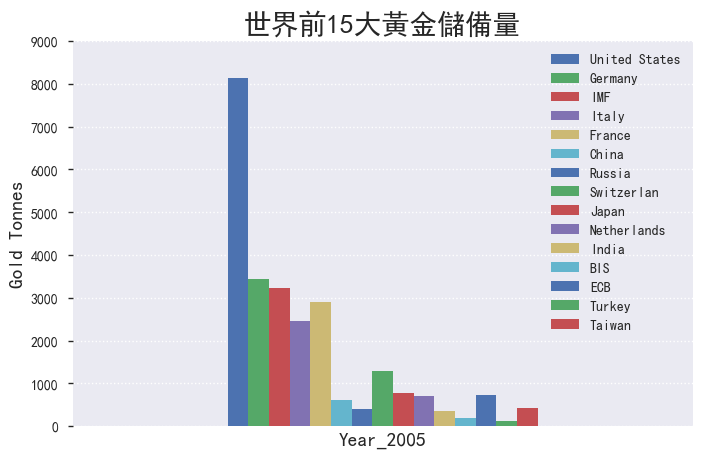

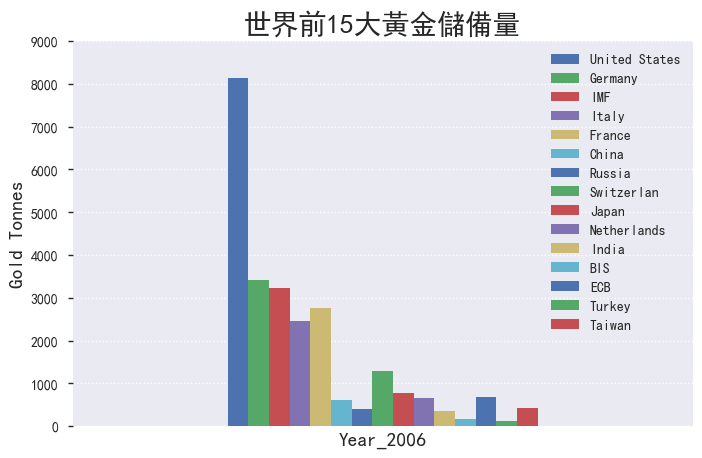

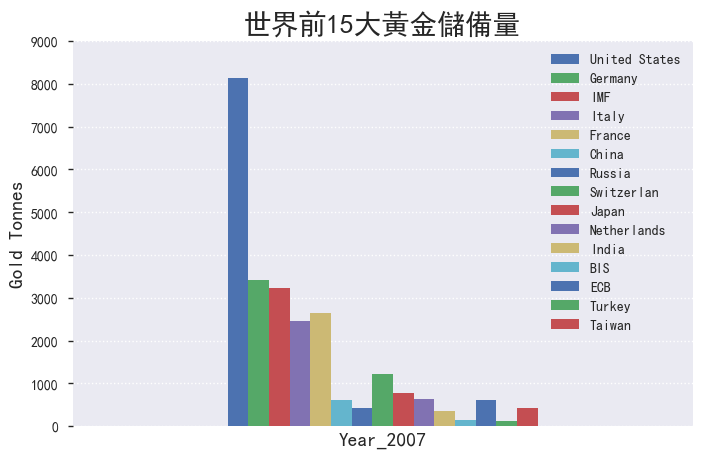

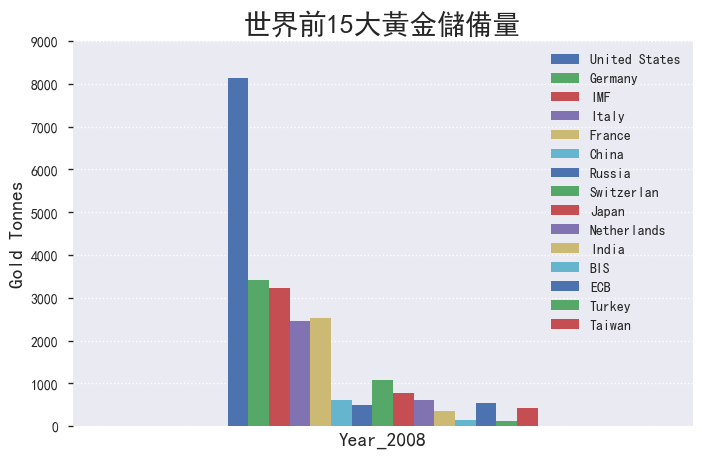

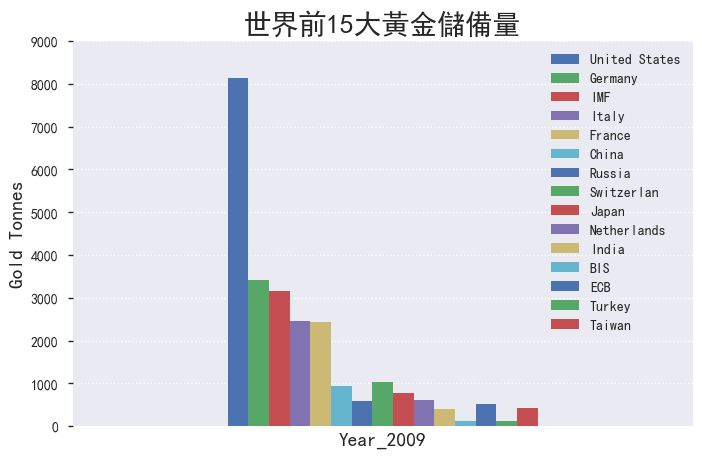

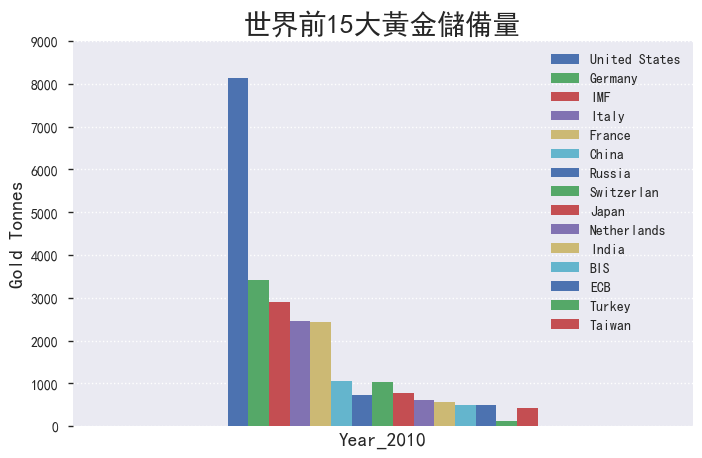

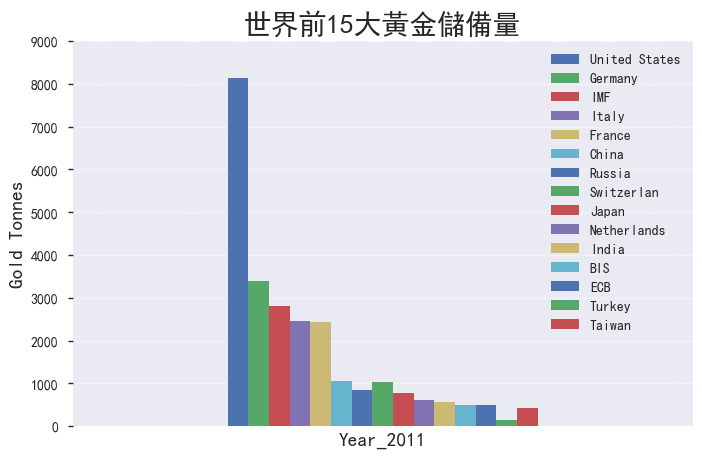

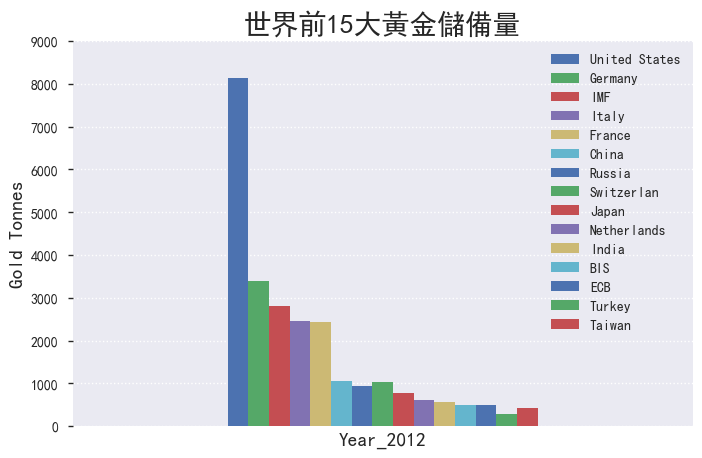

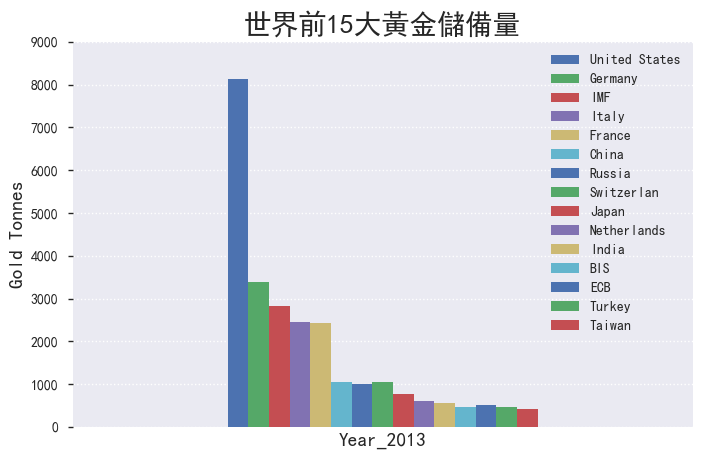

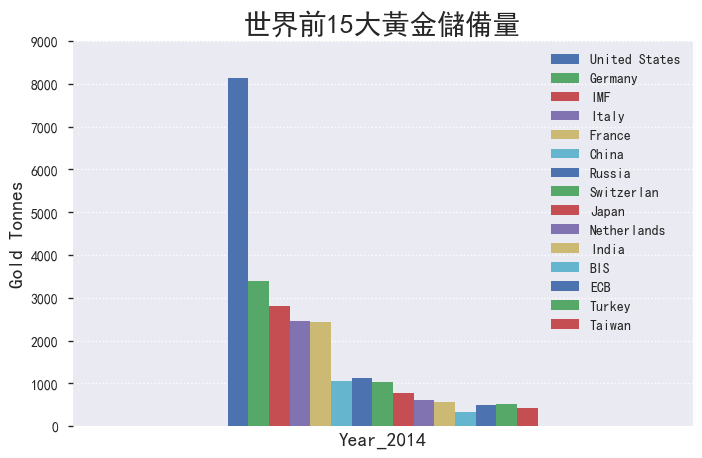

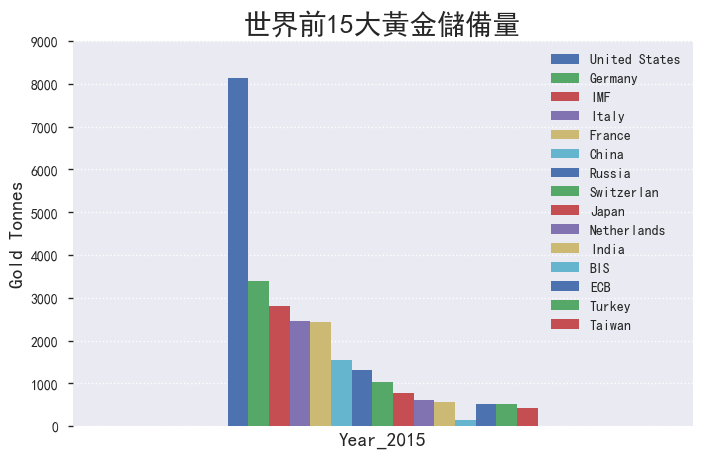

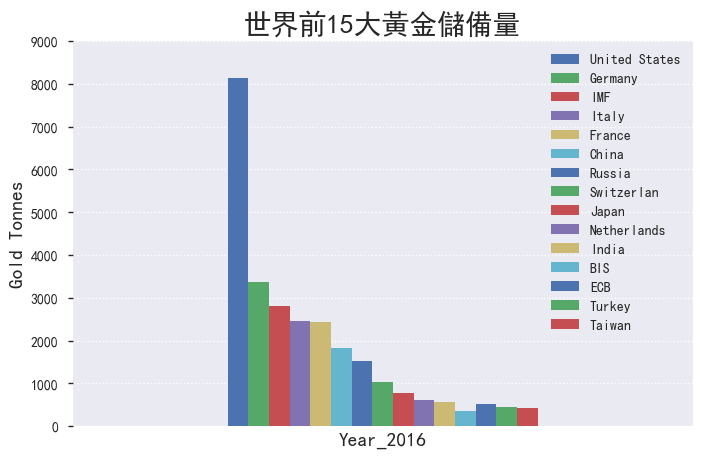

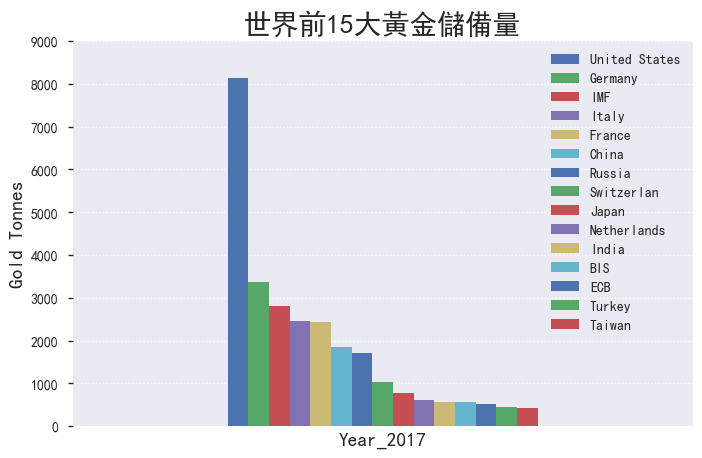

In [16]:
'''看要不要改長條圖的顏色'''

plt.rcdefaults()  ##重置 plt.rcParams
plt.style.use('seaborn')
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.labelsize'] = 14  ##設定x y軸 label 字體大小
plt.rcParams['axes.titlesize'] = 20    # 設定標題大小
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.dpi'] = 300 #圖片像素
plt.rcParams['ytick.major.size'] = 3.5  # Y軸刻度 長度
plt.rcParams['savefig.transparent'] = True  # 存檔背景透明
plt.rcParams['savefig.bbox'] = 'tight'  # 把所有的標籤都存進圖片(不會被切掉)


gr[0:1].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2000')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2000.png')

gr[1:2].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2001')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2001.png')

gr[2:3].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2002')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2002.png')

gr[3:4].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2003')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2003.png')

gr[4:5].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2004')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2004.png')

gr[5:6].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2005')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2005.png')

gr[6:7].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2006')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2006.png')

gr[7:8].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2007')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2007.png')

gr[8:9].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2008')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2008.png')

gr[9:10].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2009')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2009.png')

gr[10:11].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2010')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2010.png')

gr[11:12].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2011')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2011.png')

gr[12:13].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2012')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2012.png')

gr[13:14].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2013')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2013.png')

gr[14:15].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2014')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2014.png')

gr[15:16].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2015')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2015.png')

gr[16:17].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2016')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2016.png')

gr[17:18].plot(kind = 'bar')
plt.title('世界前15大黃金儲備量')
plt.ylabel('Gold Tonnes')
plt.xlabel('Year_2017')
plt.ylim(0,9000) 
plt.xticks([])
#plt.tight_layout()
plt.savefig('2017.png')

# 歷年前15大黃金儲備量 - 依國家別作圖

In [17]:
## 給 單一國別 vs 歷年黃金存量用
i = 2000
list_year = []
for i in range(2000, 2018):
    if 1999 < i < 2018:
        list_year.append(i)
        i+=1
    #print(i)
print(list_year)

[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


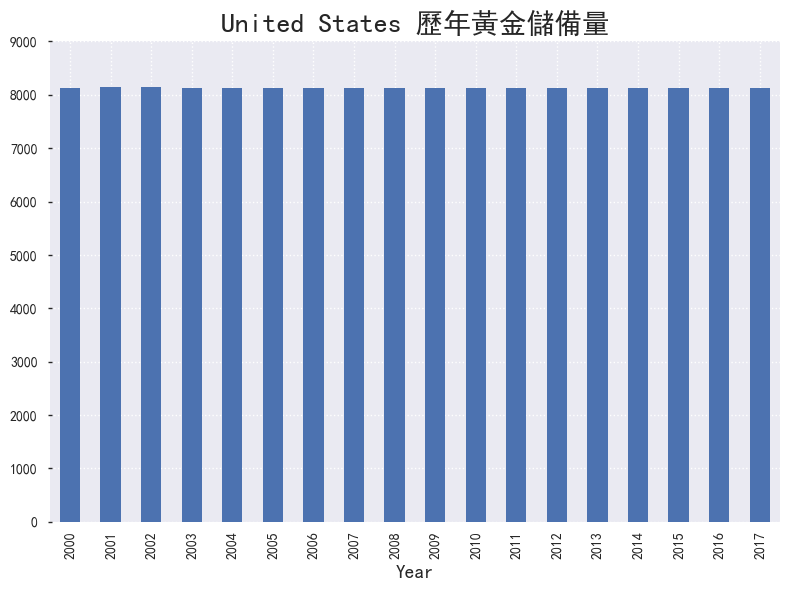

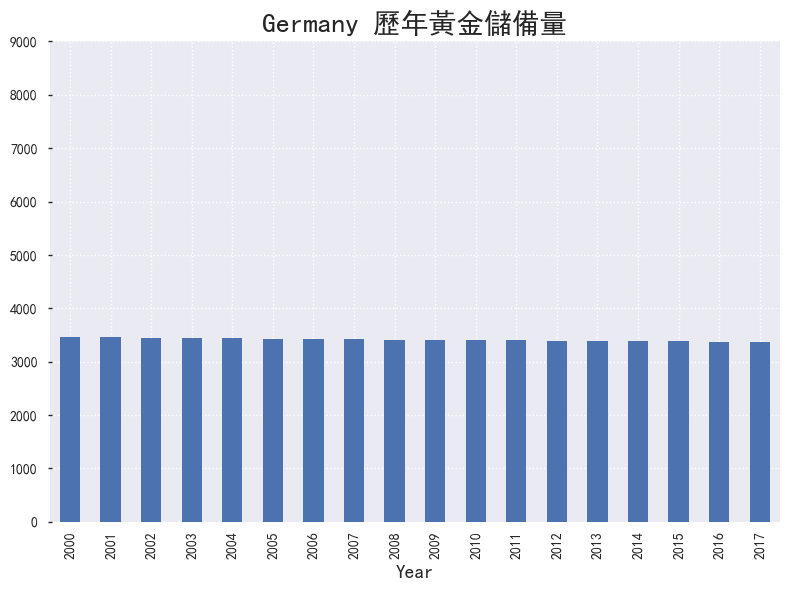

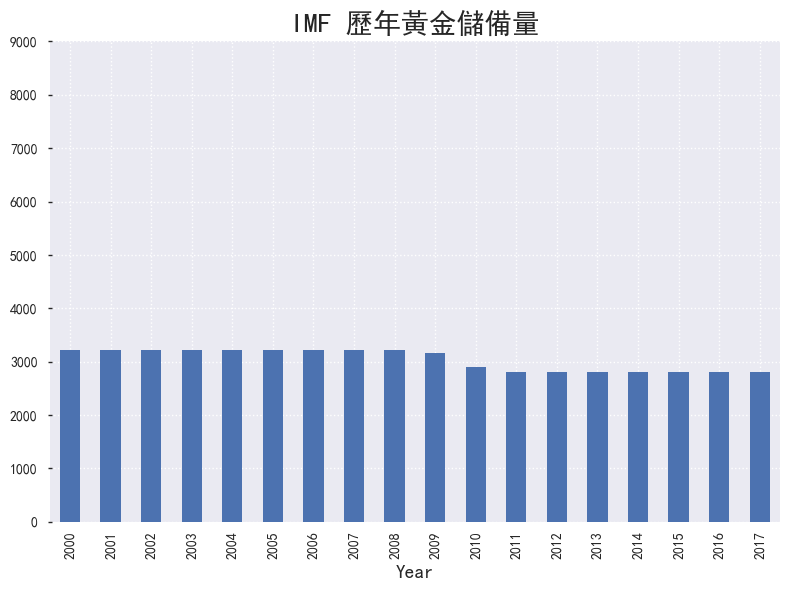

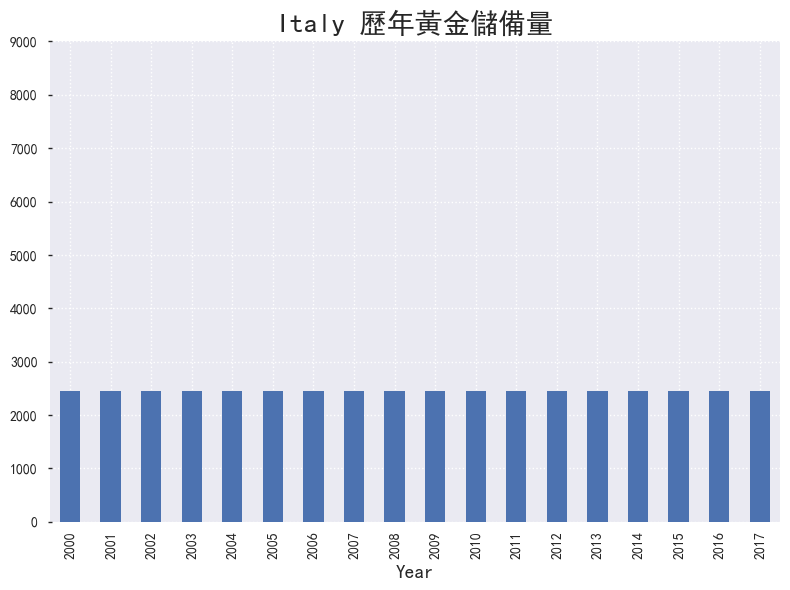

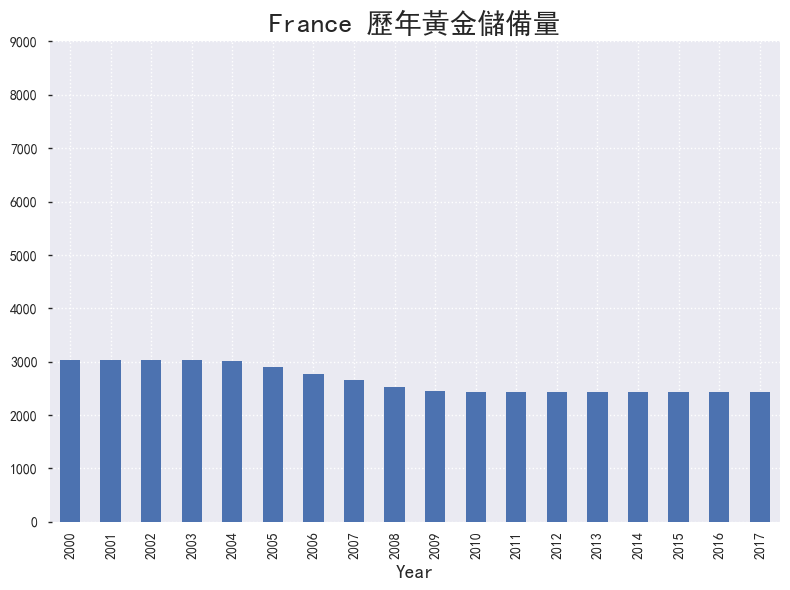

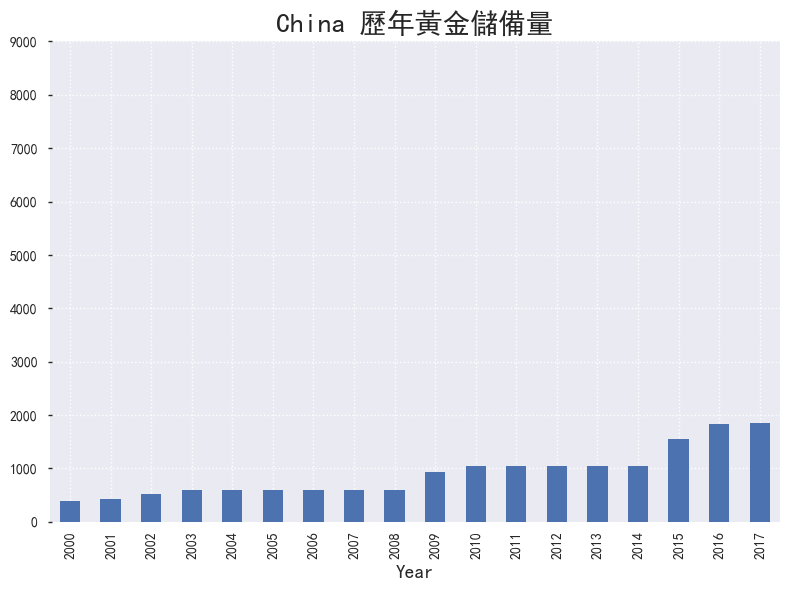

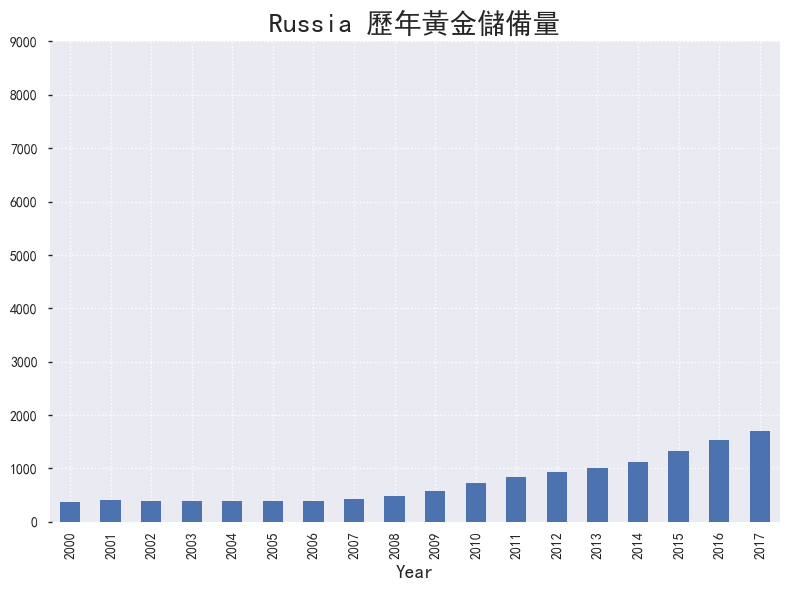

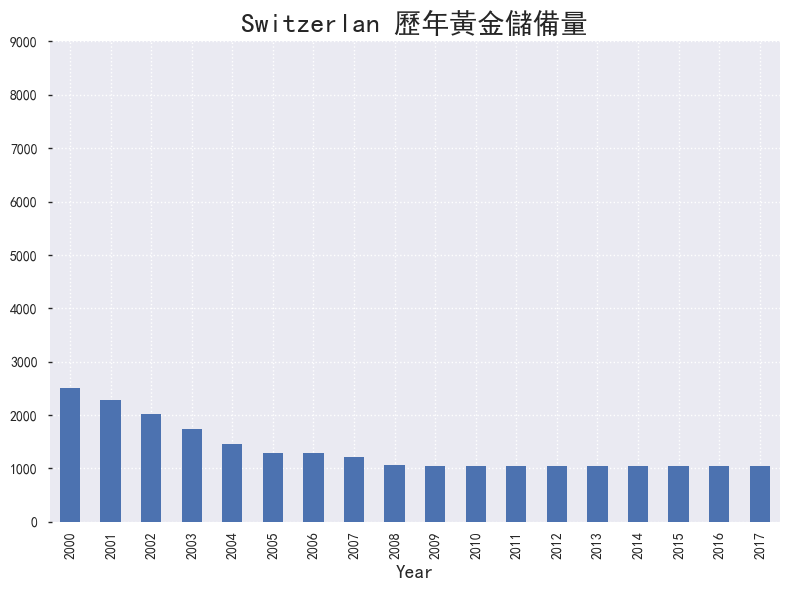

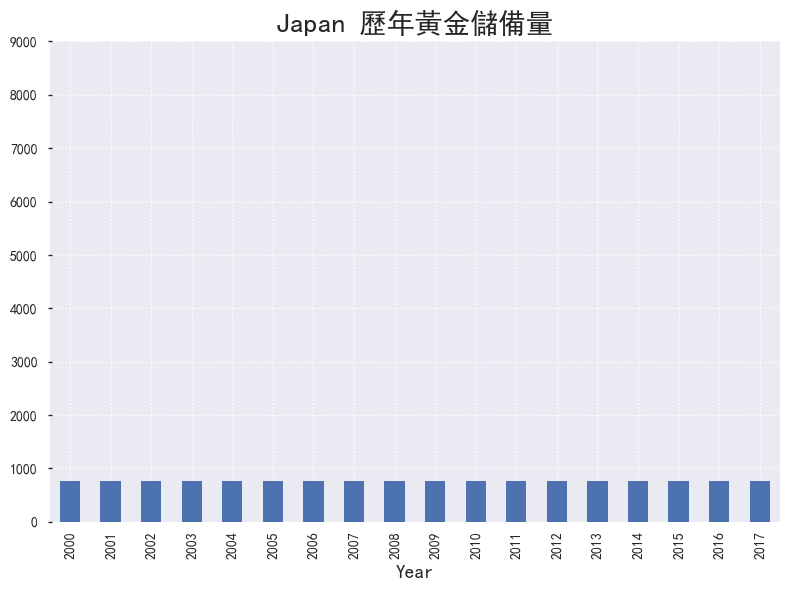

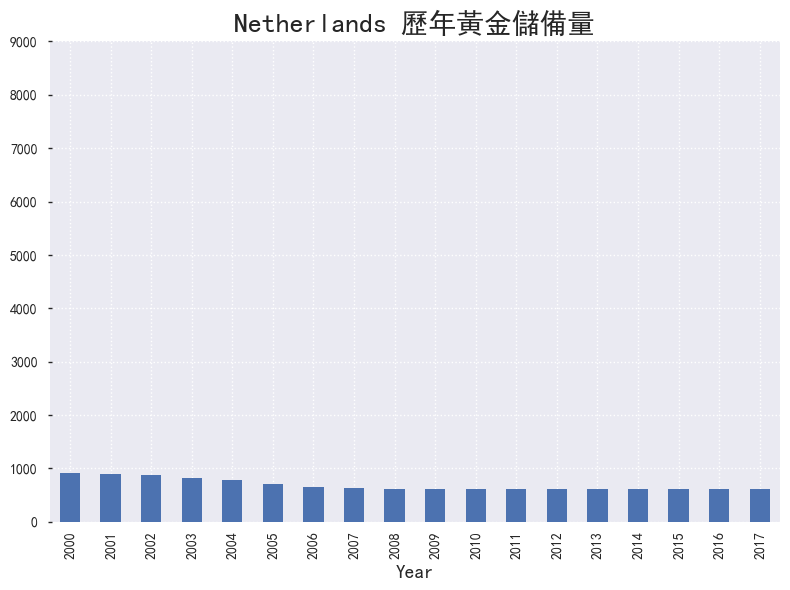

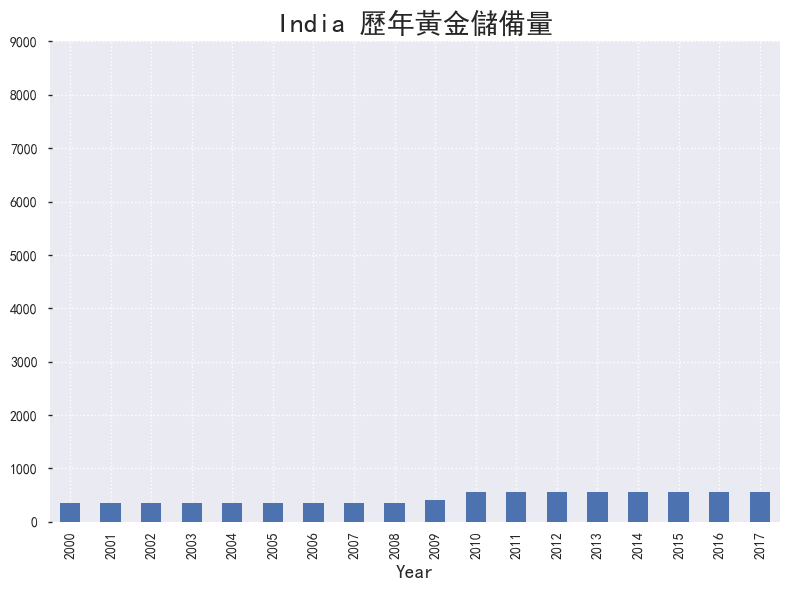

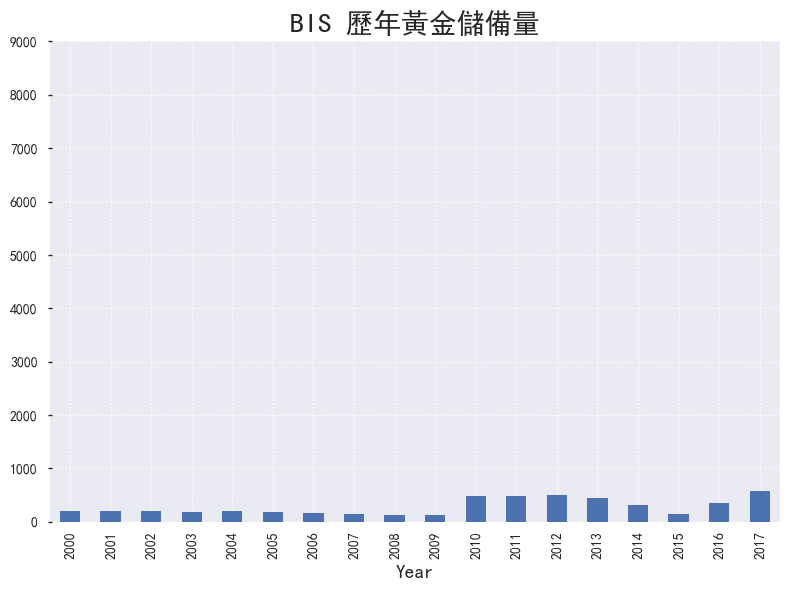

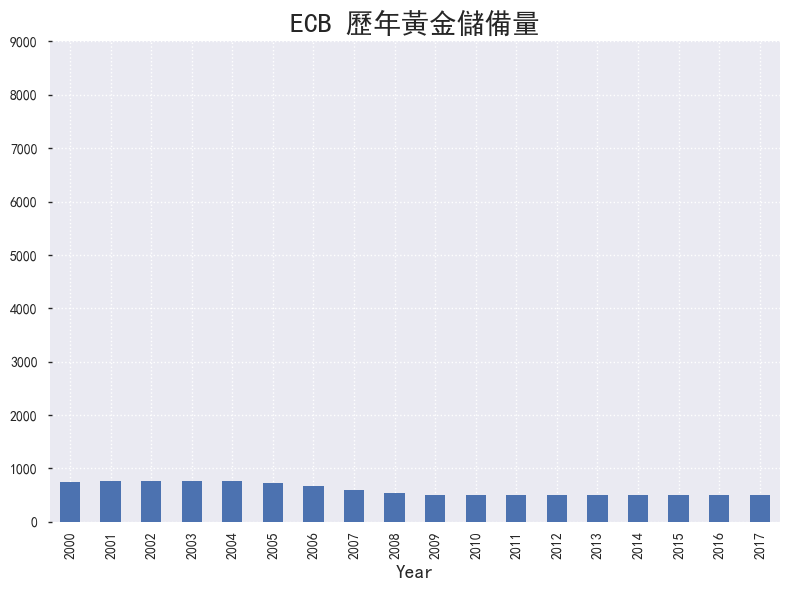

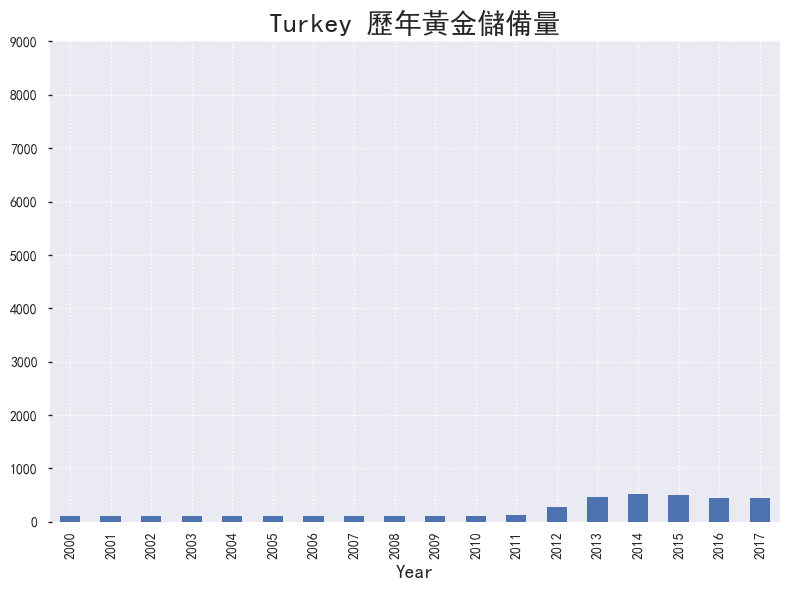

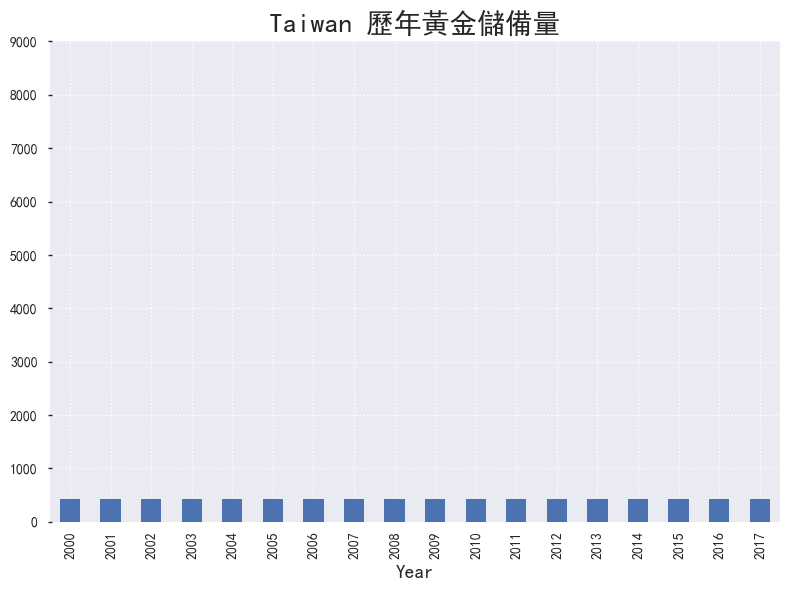

In [18]:
plt.rcdefaults()  ##重置 plt.rcParams
plt.style.use('seaborn')
plt.rcParams['font.family']='SimHei'   # 顯示中文 且為黑體
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['axes.labelsize'] = 14  ##設定x y軸 label 字體大小
plt.rcParams['axes.titlesize'] = 20    # 設定標題大小
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.dpi'] = 300 #圖片像素
plt.rcParams['xtick.direction'] = 'inout' 
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 3.5  # Y軸刻度 長度
plt.rcParams['figure.autolayout'] =True    # plt.tight_layout()
plt.rcParams['savefig.transparent'] = True  # 存檔背景透明
plt.rcParams['savefig.bbox'] = 'tight'  # 把所有的標籤都存進圖片(不會被切掉)

gr[['United States']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('United States 歷年黃金儲備量')
plt.savefig('United_States.png')

gr[['Germany']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Germany 歷年黃金儲備量')
plt.savefig('Germany.png')

gr[['IMF']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('IMF 歷年黃金儲備量')
plt.savefig('IMF.png')

gr[['Italy']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Italy 歷年黃金儲備量')
plt.savefig('Italy.png')

gr[['France']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('France 歷年黃金儲備量')
plt.savefig('France.png')

gr[['China']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('China 歷年黃金儲備量')
plt.savefig('China.png')

gr[['Russia']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Russia 歷年黃金儲備量')
plt.savefig('Russia.png')

gr[['Switzerlan']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Switzerlan 歷年黃金儲備量')
plt.savefig('Switzerlan.png')

gr[['Japan']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Japan 歷年黃金儲備量')
plt.savefig('Japan.png')

gr[['Netherlands']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Netherlands 歷年黃金儲備量')
plt.savefig('Netherlands.png')

gr[['India']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('India 歷年黃金儲備量')
plt.savefig('India.png')

gr[['BIS']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('BIS 歷年黃金儲備量')

gr[['ECB']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('ECB 歷年黃金儲備量')

gr[['Turkey']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Turkey 歷年黃金儲備量')

gr[['Taiwan']].plot(kind = 'bar', legend=False).set_xticklabels(list_year)
plt.ylim(0,9000) 
#plt.tight_layout()
plt.title('Taiwan 歷年黃金儲備量')